## Pycaret
- 지도학습
  - 분류<br>
    [Classification] https://pycaret.readthedocs.io/en/latest/api/classification.html
```python
from pycaret.classification import * 
```
  - 회귀<br>
    [Regression] https://pycaret.readthedocs.io/en/latest/api/regression.html
```python
from pycaret.regression import *
```

In [ ]:
# pycaret 가상환경을 이용해야 한다.
# conda active pycaret

In [1]:
# 기본 Package
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

# Explain with Classification Case
from pycaret.classification import *  

#### 1) Load Data

In [2]:
train = pd.read_csv('data/titanic_train.csv')
test = pd.read_csv('data/titanic_test.csv')
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name,Ticket,Cabin,Embarked
0,1,0,3,1,22.0,1,0,7.2500,"Braund, Mr. Owen Harris",A/5 21171,NaN,S
1,2,1,1,0,38.0,1,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,C
2,3,1,3,0,26.0,0,0,7.9250,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,S
3,4,1,1,0,35.0,1,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,S
4,5,0,3,1,35.0,0,0,8.0500,"Allen, Mr. William Henry",373450,NaN,S


#### 2) Data Preprocessing & Feature Engineering
$~~$ training 환경을 설정하고 수행할 Feature Engineering을 지정한다. 올바르게 설정됐다면 Enter키로 설정을 마친다.
```python
setup(데이터, target, session_id, use_gpu=True   # pd.concat([X_train, y_train], axis=1), y_train, random state, gpu 사용
      fix_imbalance=True,                        # 데이터 불균형을 고려해 train, validation 데이터 분리 
      fold, fold_strategy,                       # CV의 fold 수, fold 알고리즘(kfold/stratifiedkfold/groupkfold),
      fold_shuffle=True,                         # - kfold/stratifiedkfold시 임의로 fold를 선택하게 설정
      fold_groups,                               # - groupfold시 각 fold 내 데이터수 설정
      profile=True,                              # setup 끝난 데이터의 EDA 출력(별도의 EDA 사용 권장)
      
   '''1. Use External Features'''
         preprocess=False,                                        # Feature Engineering까지 된 데이터를 사용할 경우 
   '''2. Use Raw Data'''
      # Setting Environment
         ignore_features,                                          # 사용하지 않을 feature 지정
         categorical_features, ordinal_features, numeric_features, # feature의 dtype 설정
      # Preprocessing
         imputation_type,                                          # 결측치 처리(simple/iterative(회귀))
         categorical_iterative_imputer, numeric_iterative_imputer, # iterative의 회귀 모델 설정
         remove_outliers=True, outliers_threshold,                # 이상치 제거, 이상치 정의 기준
         normalize=True, normalize_method,                        # 정규화, 정규화 알고리즘 설정(zscore/minmax/maxabs/robust)
         transformation=True,                                     # 변환
      # Make Features
         polynomial_features=True,                                # 기존의 수치형 변수로 다항변수를 생성
         polynomial_degree, interaction_threshold,                 # 생성할 다항변수 차원수 지정, 삭제할 Target과의 상관관계 기준
      
    # Reduce Features
      combine_rare_levels=True,                  # LGBM처럼 Category feature을 합침
      rare_level_threshold,                      # 변수에서 threshold 밑의 비율을 갖는 범주만 합침 
    # Drop Features
      remove_multicollinearity=True,             # 다중공산성에 따라 제거(Overfitting)
      multicollinearity_threshold,               # Target과의 상관관계 기준 
      ignore_low_variance=True,                  # 상관관계가 적은 Categorical feature 제거(Underfitting)
      feature_selection=True,                    # 유용한 피쳐만 사용
      feature_selection_method)                  # 선택 알고리즘 설정
```

In [3]:
# setup함수가 자동으로 전처리한 것은 초록색으로 알린다.
survived = setup(train, target='Survived', 
                 numeric_features=['Pclass', 'SibSp', 'Parch'], 
                 ignore_features=['PassengerId','Name', 'Ticket', 'Cabin'],
                 session_id=123, 
                 normalize=True, 
                 remove_multicollinearity=True,
                 ignore_low_variance=True,
                 fold_shuffle=True)

,Description,Value
0,session_id,123
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(891, 12)"
5,Missing Values,1
6,Numeric Features,5
7,Categorical Features,2
8,Ordinal Features,0
9,High Cardinality Features,0


In [4]:
# 전처리한 데이터
X_train, X_dev, y_train, y_dev = get_config('X_train'), get_config('X_test'), get_config('y_train'), get_config('y_test')
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_0,Embarked_C,Embarked_Q,Embarked_S,Embarked_not_available
416,-0.386505,0.323710,0.422790,0.809104,-0.015230,1.0,0.0,0.0,1.0,0.0
801,-0.386505,0.087673,0.422790,0.809104,-0.130344,1.0,0.0,0.0,1.0,0.0
512,-1.590470,0.481069,-0.452286,-0.467027,-0.129653,0.0,0.0,0.0,1.0,0.0
455,0.817459,-0.069685,-0.452286,-0.467027,-0.468397,0.0,1.0,0.0,0.0,0.0
757,-0.386505,-0.935156,-0.452286,-0.467027,-0.402014,0.0,0.0,0.0,1.0,0.0


#### 3) Compare Model
$~~$ 분석가의 가정에 맞게 특정 모델을 고려하거나<br>
$~~$ 교차검증에 따라 Validation data로 가능한 모델들을 평가하고 평가지표를 바탕으로 Ensemble할 모델들을 고려한다.
```python
models()                           # 데이터에 적용가능한 모델 여부 출력

# 특정 모델 생성
create_model(모델약자,
             fold)                 # Validation data를 만들 fold 수 설정            

# 성능이 높은 모델들 생성
compare_models(n_select.           # 추출할 상위 모델 수
               include, exclude.    # 평가할 모델, 평가하지 않을 모델 지정
               sort,                # 평가지표 설정
               fold,                # Validation data를 만들 fold 수 설정
               turbo=True)          # 학습이 오래 걸리는 모델 제거(default)
```

In [5]:
clfs = compare_models(n_select=5, 
                      exclude=['svm', 'ridge', 'lda', 'gbc'],  # 오래 걸리는 모델 제외 
                      sort='AUC', 
                      fold=5) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8042,0.8644,0.6968,0.7867,0.7366,0.5818,0.5869,0.0140
rf,Random Forest Classifier,0.7978,0.8588,0.7132,0.7608,0.7340,0.5715,0.5743,0.0400
lr,Logistic Regression,0.7962,0.8556,0.7217,0.7540,0.7348,0.5698,0.5730,0.5300
xgboost,Extreme Gradient Boosting,0.7865,0.8522,0.6804,0.7530,0.7141,0.5446,0.5471,0.0640
knn,K Neighbors Classifier,0.7898,0.8387,0.7216,0.7368,0.7269,0.5565,0.5587,0.4460
ada,Ada Boost Classifier,0.8026,0.8382,0.7421,0.7563,0.7466,0.5852,0.5879,0.0120
et,Extra Trees Classifier,0.7930,0.8264,0.6969,0.7594,0.7248,0.5596,0.5627,0.0300
nb,Naive Bayes,0.6405,0.8174,0.1069,0.8433,0.1859,0.1074,0.2041,0.4100
dt,Decision Tree Classifier,0.7576,0.7494,0.7007,0.6886,0.6934,0.4932,0.4944,0.0040
catboost,CatBoost Classifier,0.4832,0.5110,0.4082,0.4801,0.4394,0.3487,0.3531,0.2240


#### 4) Tune Model
$~~$ 모델의 일반화 성능을 최고 수준으로 하는 hyperparameter값을 설정한다.
```python
tune_model(모델,                       # 튜닝할 모델
           optimize,                   # 평가지표 설정
           search_library,            '''hyperparameter search 패키지 설정
                                         (scikit-learn(random grid, default)/scikit-optimize(bayesian)/optuna(Parzen))'''
           n_iter,                     # hyperparameter search 횟수 설정
           early_stopping=True,        # search 조기종료 설정
           custom_grid,                # hyperparameter별 Grid search 범위 지정
           fold,                       # Validation data를 만들 fold 수 설정
           choose_better=True)         # Validation data별 일반화된 성능을 갖는 모델로 반환
```

In [6]:
# tuning model들의 평균 평가지표값을 출력한다.
tuned_models = [tune_model(m, optimize='AUC', n_iter=30, fold=5) for m in clfs]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8160,0.8614,0.6531,0.8421,0.7356,0.5980,0.6093
1,0.7760,0.8251,0.7143,0.7143,0.7143,0.5301,0.5301
2,0.8000,0.8261,0.6122,0.8333,0.7059,0.5597,0.5749
3,0.8306,0.8717,0.6327,0.9118,0.7470,0.6259,0.6495
4,0.7984,0.8871,0.7292,0.7447,0.7368,0.5735,0.5736
Mean,0.8042,0.8543,0.6683,0.8092,0.7279,0.5774,0.5875
SD,0.0184,0.0248,0.0457,0.0712,0.0153,0.0327,0.0399


#### 5) Ensemble Models
```python
# averaging
blend_models(estimator_list,          # 앙상블할 모델들   
             optimize,                # 평가지표 설정
             method,                  # blending 방법(auto/sort/hard)
             weights,                 # weak model별 가중치
             fold,                    # Validation data를 만들 fold 수 설정
             choose_better=True)      # Validation data별 일반화된 성능을 갖는 모델로 반환
                
# stacking
stack_models(estimator_list,          # 앙상블할 모델들
             fold,                    # 앙상블할 모델들의 Validation data를 만들 fold 수 설정
             meta_model,              # stacker의 모델
             meta_model_fold,         # stacker의 Validation data를 만들 fold 수 설정
             optimize,                # 평가지표 설정
             choose_better=True)      # stacker의 Validation data별 일반화된 성능을 갖는 모델로 반환
```

In [7]:
# Averaging
blender = blend_models(estimator_list=tuned_models, method='soft', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7840,0.8597,0.7959,0.6964,0.7429,0.5581,0.5618
1,0.7840,0.8514,0.8163,0.6897,0.7477,0.5612,0.5673
2,0.8080,0.8551,0.7143,0.7778,0.7447,0.5913,0.5927
3,0.8387,0.8963,0.8571,0.7636,0.8077,0.6696,0.6729
4,0.7984,0.9016,0.9167,0.6769,0.7788,0.6011,0.6245
Mean,0.8026,0.8728,0.8201,0.7209,0.7643,0.5963,0.6038
SD,0.0202,0.0216,0.0671,0.0414,0.0254,0.0403,0.0411


In [8]:
# Stacking
stacker = stack_models(estimator_list=tuned_models, meta_model=create_model('lr'), fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7920,0.8449,0.7143,0.7447,0.7292,0.5605,0.5608
1,0.7920,0.8390,0.6939,0.7556,0.7234,0.5572,0.5585
2,0.8240,0.8677,0.6735,0.8462,0.7500,0.6169,0.6265
3,0.8629,0.8963,0.7959,0.8478,0.8211,0.7101,0.7111
4,0.8226,0.8936,0.8125,0.7500,0.7800,0.6317,0.6332
Mean,0.8187,0.8683,0.7380,0.7888,0.7607,0.6153,0.6180
SD,0.0262,0.0238,0.0558,0.0476,0.0361,0.0559,0.0562


### 6) Select Model
$~~$ 만들어진 모델들 중 Validation 데이터로 평가한 결과가 가장 우수한 모델을 선택한다.
```python
automl(optimize)     # 평가지표 설정
```

In [9]:
best_model = automl(optimize='AUC')

### 7) Evaluate Model
```python
plot_model(모델, 
           plot)  # plot종류 설정
                  ''' Classification '''
                    # (auc(roc-auc plot)/confusion_matrix/class_report(평가지표표)/
                    #  rfe(Recursive Feature Selection)/feature_all(Feature Importance)/
                    #  parameter(hyperparemter)/tree(Decision Tree Node)
                  ''' Regression '''
                    # (residuals/residuals_interactive/
                    #  rfe(Recursive Feat Selection)/feature_all(Feature Importance)/
                    #  parameter(hyperparemter)/tree(Decision Tree Node)
```        

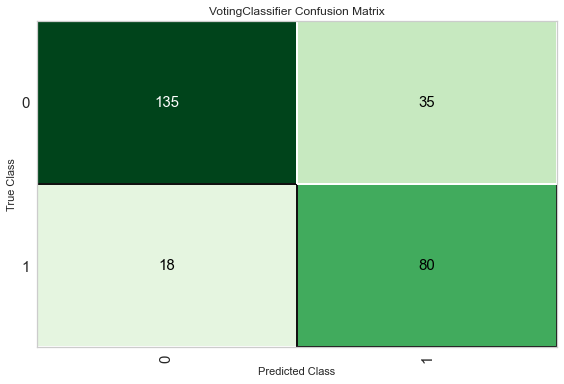

In [10]:
plot_model(best_model, plot='confusion_matrix') 

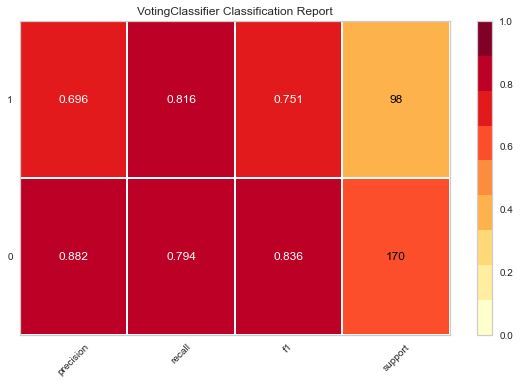

In [11]:
plot_model(best_model, plot='class_report')

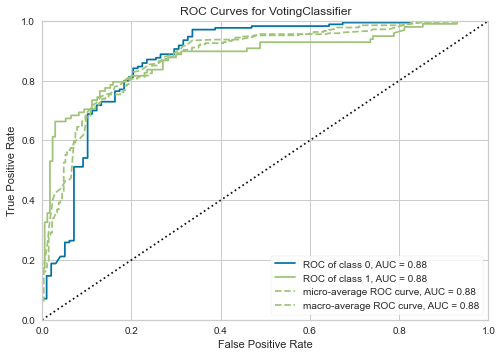

In [12]:
plot_model(best_model, plot='auc')

### 8. Pull Predict & Deploy Model
$~~$ target값과 그 값이라 예측한 확률을 뽑아내고 모델을 만들기까지의 전체 pipeline을 저장한다.
```python
# predict y_test
predict_model(모델, data)       # best model, X_test

# save model
save_model(모델, model_name)    # best_model, pkl명
```

In [13]:
# pd.concat([X_test, pred_label, probability of pred_label], axis=1)형태로 출력된다.
pred = predict_model(best_model, data=test) 
pred

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name,Ticket,Cabin,Embarked,Label,Score
0,496,0,3,1,NaN,0,0,14.4583,"Yousseff, Mr. Gerious",2627,NaN,C,0,0.6537
1,649,0,3,1,NaN,0,0,7.5500,"Willey, Mr. Edward",S.O./P.P. 751,NaN,S,0,0.8389
2,279,0,3,1,7.0,4,1,29.1250,"Rice, Master. Eric",382652,NaN,Q,0,0.6991
3,32,1,1,0,NaN,1,0,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",PC 17569,B78,C,1,0.8905
4,256,1,3,0,29.0,0,2,15.2458,"Touma, Mrs. Darwis (Hanne Youssef Razi)",2650,NaN,C,1,0.7098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,364,0,3,1,35.0,0,0,7.0500,"Asim, Mr. Adola",SOTON/O.Q. 3101310,NaN,S,0,0.8578
353,407,0,3,1,51.0,0,0,7.7500,"Widegren, Mr. Carl/Charles Peter",347064,NaN,S,0,0.8152
354,867,1,2,0,27.0,1,0,13.8583,"Duran y More, Miss. Asuncion",SC/PARIS 2149,NaN,C,1,0.7665
355,882,0,3,1,33.0,0,0,7.8958,"Markun, Mr. Johann",349257,NaN,S,0,0.7533


In [14]:
# pd.concat([test_ID, probability of pred_label], axis=1)로 제출 파일을 만든다.
pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred.Score}).to_csv('titanic_submission.csv', index=False)
pd.read_csv('titanic_submission.csv')

,PassengerId,Survived
0,496,0.6537
1,649,0.8389
2,279,0.6991
3,32,0.8905
4,256,0.7098
...,...,...
352,364,0.8578
353,407,0.8152
354,867,0.7665
355,882,0.7533


In [15]:
# save model
save_model(best_model, model_name = 'titanic_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['PassengerId', 'Name',
                                                        'Ticket', 'Cabin'],
                                       id_columns=['PassengerId'],
                                       ml_usecase='classification',
                                       numerical_features=['Pclass', 'SibSp',
                                                           'Parch'],
                                       target='Survived', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_av...
                                                              n_estimators=210,
                                                              n_jobs=-1,
                                                              nu